In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import LSTM
from keras import optimizers as opt

import mbspbs10pc.model as mbs_model
from mbspbs10pc import read_activations, utils
reload(mbs_model)
reload(read_activations)
reload(utils);

/home/samu/miniconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Load data

In [3]:
labelsfile = '../../tmp/1_METONLY_vs_METX/matched_CEM_table.csv'
datafile = '../../tmp/item_days_raw_data_.pkl'
dataset = utils.load_data_labels(datafile, labelsfile)
padded_mbs_seq, padded_timestamp_seq, _ = utils.tokenize(dataset)
maxlen = padded_mbs_seq.shape[1]

# Split in training, validation, test sets
tr_set, v_set, ts_set = utils.train_validation_test_split(
    [padded_mbs_seq, padded_timestamp_seq], dataset['Class'],
    test_size=0.4, validation_size=0.1,
    verbose=False)

In [4]:
# x = tr_set[0][0]
# t = tr_set[0][1].squeeze()

# Load model

In [5]:
model = mbs_model.build_model(mbs_input_shape=(maxlen,),
                              timestamp_input_shape=(maxlen, 1),
                              vocabulary_size=2774,
                              embedding_size=50,
                              recurrent_units=64,
                              dense_units=64,
                              bidirectional=True,
                              LSTMLayer=LSTM)

model.load_weights('../../tmp/auc_858/output_weights.h5')

# Visualize the attention weights

In [6]:
a = read_activations.get_activations(model, ts_set[0], print_shape_only=True, layer_name='tsg_attention')[0]
x1 = read_activations.get_activations(model, ts_set[0], print_shape_only=True, layer_name='mbs_lstm')[0]
x2 = read_activations.get_activations(model, ts_set[0], print_shape_only=True, layer_name='timestamp_lstm')[0]

----- activations -----
(4698, 445, 128)
----- activations -----
(4698, 445, 128)
----- activations -----
(4698, 445, 128)


In [7]:
avg_a = np.mean(a, axis=-1).squeeze()
avg_x1 = np.mean(x1, axis=-1).squeeze()
avg_x2 = np.mean(x2, axis=-1).squeeze()
print(avg_a.shape)
print(avg_x1.shape)
print(avg_x2.shape)

(4698, 445)
(4698, 445)
(4698, 445)


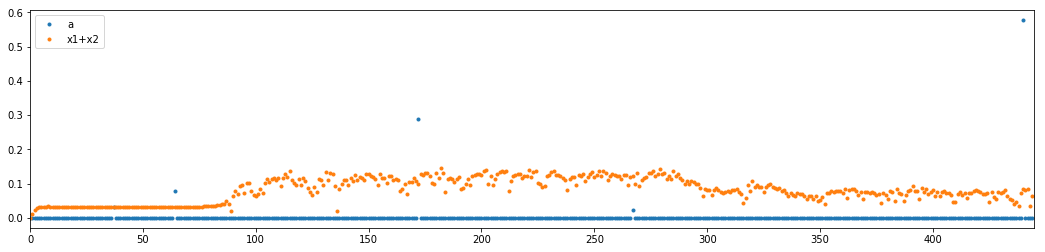

In [13]:
xaxis = np.arange(avg_a.shape[1])

plt.figure(figsize=(18,4))
for i in np.random.randint(0, avg_a.shape[0], size=1):
    plt.plot(xaxis, avg_a[i, :], '.',label=str('a'))
#     plt.plot(xaxis, avg_x1[i, :], '.',label=str('x1'))
#     plt.plot(xaxis, avg_x2[i, :], '.',label=str('x2'))
    plt.plot(xaxis, avg_x1[i, :]+avg_x2[i, :], '.',label=str('x1+x2'))
plt.xlim([0, 445])
plt.legend(loc='best')